# Test computational cost of Stochastic Programming (Scenario Optimisation)

Investigate computational complexity and runtime of scnearios optimisation for system design problem, where each scenario uses a realisation of uncertain battery efficiencies.

In [2]:
import os
import csv
import time
import random
import numpy as np

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from citylearn.citylearn import CityLearnEnv
from linmodel import LinProgModel
from schema_builder import build_schema
from sys_eval import evaluate_system

In [3]:
# set up test parameters
dataset_dir = os.path.join('A37_example_validate') # dataset directory
schema_path = os.path.join('data', dataset_dir, 'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

In [4]:
# Set up base parameters of system.
ids = [5,11,14,16,24,29]

base_kwargs = {
    'output_dir_path': os.path.join('data','A37_example_validate'),
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': [3127.0,2736.0,2746.0,2448.0,4788.0,4565.0], # from Annex 37
    'battery_power_capacities': [391.0,342.0,343.0,306.0,598.0,571.0], # from Annex 37
    'battery_efficiencies': None,
    'pv_power_capacities': [178.0,41.0,57.0,120.0,1349.0,257.0], # from Annex 37
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [5]:
# Set up probabilistic model of effiencies and take draws
n_draws = 10 #1000
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_draws,len(ids)))
eta_samples.clip(0,1)

array([[0.78700696, 0.84216175, 0.96250482, 0.8576484 , 0.84355569,
        0.76216099],
       [0.89831508, 0.89735139, 0.86140344, 0.82999223, 0.76087978,
        0.78665659],
       [0.80103341, 0.7268931 , 0.95757656, 0.85710182, 0.7648921 ,
        0.79856298],
       [0.82970593, 0.77274833, 0.84504372, 0.67911983, 0.81230742,
        0.85914827],
       [0.8525237 , 0.82378435, 0.93582569, 0.93569263, 0.925676  ,
        1.        ],
       [0.82473597, 0.74888711, 0.89284844, 0.90450251, 0.85336306,
        0.677081  ],
       [1.        , 0.954399  , 0.70900145, 0.83552432, 1.        ,
        0.85227657],
       [1.        , 1.        , 0.95173242, 0.94638898, 0.91641903,
        0.92980282],
       [0.96662903, 0.71805032, 0.74477552, 0.9933071 , 0.95130664,
        0.87656147],
       [0.87651576, 0.93716136, 0.95764952, 0.92146501, 0.90165698,
        0.79525891]])

In [6]:
#num_scenarios = [1,2,3,5,8,10,15,20]
num_scenarios = [1,2]
runtimes = {}

for M in num_scenarios:
    print(f"# Scenarios: {M}")

    etas = eta_samples[:M] # get M samples

    for m in range(M):
        # Build schema.
        base_kwargs.update({
                'battery_efficiencies': etas[m]
            })
        schema_path = build_schema(**base_kwargs)

        # Initialise CityLearn environment object.
        env = CityLearnEnv(schema=schema_path)

        if m == 0: # initialise lp object
            lp = LinProgModel(env=env)
        else:
            lp.add_env(env=env)

    lp.set_time_data_from_envs()
    lp.generate_LP(clip_level='b',design=True,pricing_dict=pricing_dict,opex_factor=opex_factor)
    lp.set_LP_parameters()

    start = time.time()
    lp_results = lp.solve_LP(verbose=False,ignore_dpp=True)
    end = time.time()

    runtimes.update({M: end-start})
    print(f"Solve time: {round(runtimes[M],1)}s")

# Scenarios: 1
Solve time: 47.5s
# Scenarios: 2
Solve time: 197.3s


In [7]:
# Fit linear trend to log(runtime)
trend = np.polyfit(np.log(list(runtimes.keys())),np.log(list(runtimes.values())),deg=1)
print(trend)

[2.05414525 3.86084552]


In [8]:
# Find max allowable samples
runtime_limit = 60*60*24*5
scenarios_limit = np.exp((np.log(runtime_limit) - trend[1])/trend[0])
print(scenarios_limit)

84.56597734927792


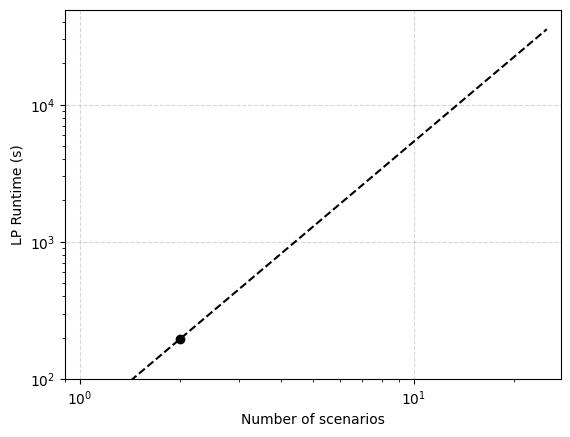

In [9]:
# Plot computational time results
max_scenarios = 25

plt.plot(runtimes.keys(),runtimes.values(),'ok')
plt.plot(np.arange(1,max_scenarios+1),np.exp(np.log(np.arange(1,max_scenarios+1))*trend[0] + trend[1]),'k--')
plt.xlabel("Number of scenarios")
plt.xscale('log')
plt.ylabel('LP Runtime (s)')
plt.yscale('log')
plt.xlim(0.9,max_scenarios*1.1)
plt.ylim(10)
plt.grid(True,'major',alpha=0.5,linestyle='--')
plt.show()

In [10]:
# Compute MC estimate of true system cost

base_kwargs.update({ # set system to best scenario optimised design (latest)
    'battery_energy_capacities': lp_results['battery_capacities'],
    'pv_power_capacities': lp_results['solar_capacities']
})

cost_evals = []

# TODO: add multiprocessing to speed up
# add tqdm supress flag, use disable=True kwarg
# need to build schemas programmatically and then clean up

for j in range(n_draws):

    etas = eta_samples[j]

    # Build schema.
    base_kwargs.update({
            'battery_efficiencies': etas
        })
    schema_path = build_schema(**base_kwargs)

    eval_results = evaluate_system(schema_path,pricing_dict,opex_factor)

    cost_evals.append(eval_results['objective'])

17600it [01:31, 191.84it/s]                           


Evaluation complete.


17600it [01:30, 195.33it/s]                           


Evaluation complete.


17600it [01:28, 197.97it/s]                           


Evaluation complete.


17600it [02:41, 109.13it/s]                           


Evaluation complete.


17600it [01:29, 196.73it/s]                           


Evaluation complete.


17600it [01:29, 196.29it/s]                           


Evaluation complete.


17600it [01:29, 197.29it/s]                           


Evaluation complete.


17600it [05:09, 56.79it/s]                            


Evaluation complete.


17600it [01:29, 197.67it/s]                           


Evaluation complete.


17600it [01:30, 195.48it/s]                           

Evaluation complete.


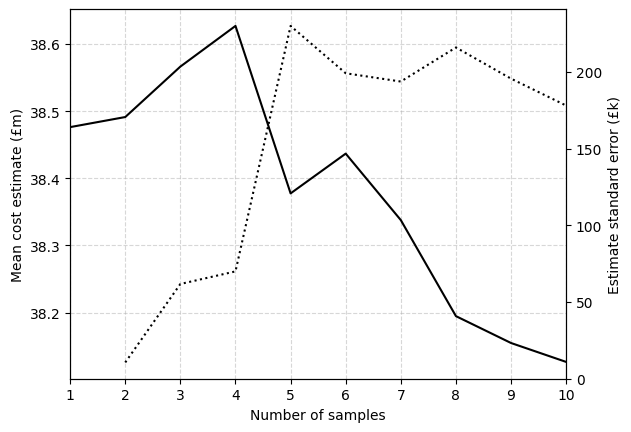

In [19]:
# Plot convergence of MC estimate
MC_means = [np.mean(cost_evals[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_evals[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)


plt.show()

To find a reasonable value of MC estimates needed we could repeat this analysis for a number of seeds and find the average number of samples needed for the standard error to fall below a given threshold, e.g. £100k, are initially peaking

In [12]:
print(cost_evals)
print(MC_means)
print(MC_stnd_errors)

[38476288.856891274, 38506300.095534496, 38716755.36278151, 38808637.21882324, 37379971.72065287, 38732890.514260136, 37743742.77730387, 37193637.605663694, 37834454.19338772, 37873117.333577104]
[38476288.856891274, 38491294.47621289, 38566448.10506909, 38626995.38350763, 38377590.65093668, 38436807.29482392, 38337798.07803535, 38194778.01898889, 38154742.03836654, 38126579.5678876]
[10610.575178214862, 61769.05446364107, 69968.93056910789, 229989.98521635795, 199135.8525600586, 193744.0880085651, 215955.98142676253, 195636.80256959656, 178088.62027106163]
